In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
raw_data = pd.read_csv("./final_input/input.csv")
raw_data.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
# 元のデータ
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 30 columns):
rank                    1999 non-null int64
name                    1999 non-null object
channel_name            254 non-null object
office                  133 non-null object
official                1118 non-null object
dimention               1118 non-null object
voice                   1091 non-null object
fans                    1906 non-null float64
video_count             1906 non-null float64
duration                1906 non-null float64
like_count              1892 non-null float64
dislike_count           1892 non-null float64
comment_count           1905 non-null float64
islive                  1906 non-null float64
tag_count               1906 non-null float64
view_count_per_video    1906 non-null float64
video_publish_delta     1820 non-null float64
Youtube_days            1906 non-null float64
follow                  1714 non-null float64
follower                1714 

In [4]:
# fillna できない欠損値は考えないものとする
data = raw_data[~raw_data[["official", "voice", "video_publish_delta", "delta_tweet_sec"]].isna().any(axis=1)
                & (raw_data.video_count > 1)]
# これらは0でfillna
data.loc[:, ["like_count", "dislike_count", "comment_count"]] = data.loc[:, ["like_count", "dislike_count", "comment_count"]].fillna(0)

C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 1997
Data columns (total 30 columns):
rank                    912 non-null int64
name                    912 non-null object
channel_name            188 non-null object
office                  98 non-null object
official                912 non-null object
dimention               912 non-null object
voice                   912 non-null object
fans                    912 non-null float64
video_count             912 non-null float64
duration                912 non-null float64
like_count              912 non-null float64
dislike_count           912 non-null float64
comment_count           912 non-null float64
islive                  912 non-null float64
tag_count               912 non-null float64
view_count_per_video    912 non-null float64
video_publish_delta     912 non-null float64
Youtube_days            912 non-null float64
follow                  912 non-null float64
follower                912 non-null float64
fav

# EDA

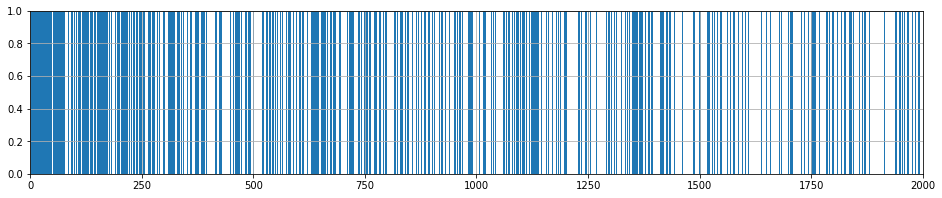

In [6]:
# 欠損しているデータの分布をみる
plt.figure(figsize=(16, 3))
data["rank"].hist(bins=2000)
plt.xlim(0, 2000)
plt.ylim(0, 1)
plt.savefig("./picture/欠損.png")

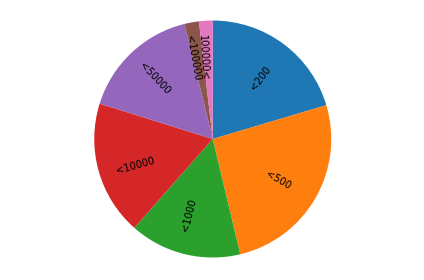

In [7]:
# 目的変数の分布をみる
fans = data.fans
cut = [200, 500, 1000, 5000, 50000, 100000]
labels = ["<200", "<500", "<1000", "<10000", "<50000", "<100000", "100000<"]


pd.Series(np.array(labels)[np.searchsorted(cut, fans)]).value_counts()[labels].plot.pie(startangle=90,
                                                                                        counterclock=False,
                                                                                        rotatelabels=True,
                                                                                        labeldistance=0.5)
plt.ylabel("")
plt.axis("equal")
plt.tight_layout()
plt.savefig("./picture/fans_pie.png")

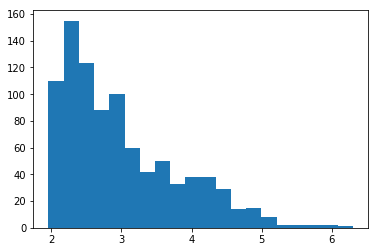

In [8]:
# この手のデータは予測にlogをとるべき
plt.hist(np.log10(fans), bins=20)
plt.savefig("./picture/fans_hist.png")

In [9]:
# 上位がチャンネル登録者数に影響するのは当たり前なので、別の特徴量に置き換える

data["like_per_view"] = data["like_count"] / data["view_count_per_video"]
data["dislike_per_view"] = data["dislike_count"] / data["view_count_per_video"]
data["comment_per_view"] = data["comment_count"] / data["view_count_per_video"]

# 0で割らないよう0.01を足す
data["like_per_vote"] = data["like_count"] / (0.01 + data["like_count"] + data["dislike_count"])
data["dislike_per_vote"] = data["dislike_count"] / (0.01 + data["like_count"] + data["dislike_count"])

data["follow_back_rate"] = data["follow"] / data["follower"]


# カテゴリ値はone-hot encoding
data = pd.concat([data, pd.get_dummies(data[["official", "dimention", "voice"]], drop_first=True)], axis=1)


data = data.rename(columns={"official_個人": "is_personal",
                            "dimention_二次元": "is_2D",
                            "voice_機械": "voice_machine",
                            "voice_男": "voice_male"})

C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [10]:
# 目的変数との相関を見る
# cor>0.2のものは直接登録者数とかかわっているので、これを使って回帰してもつまらない

from scipy.stats import spearmanr, pearsonr

tmp = {}

for col in data.select_dtypes(["float"]).drop("fans", axis=1).columns:
    cor, p = spearmanr(data[col], data["fans"])
    tmp[col] = {"cor": cor, "p": p}

cordf = pd.DataFrame(tmp).T
cordf.sort_values(by="p")

,cor,p
view_count,0.902291,0.000000e+00
view_count_per_video,0.858258,7.296896e-266
like_count,0.858069,1.277719e-265
follower,0.826337,3.899476e-229
dislike_count,0.719340,3.775039e-146
comment_count,0.715913,3.828176e-144
follow_back_rate,-0.596514,5.511969e-89
comment_per_view,-0.443722,2.792852e-45
video_count,0.293065,1.604495e-19
mentioned,0.255418,4.757232e-15


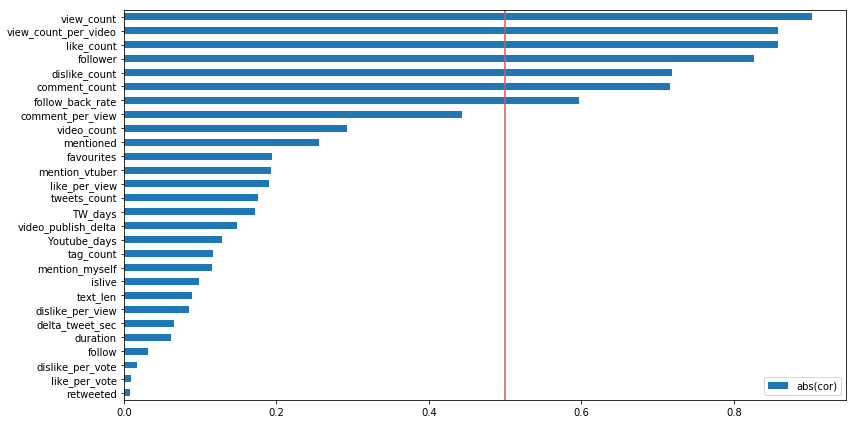

In [11]:
cordf["abs(cor)"] = np.abs(cordf.cor)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
cordf.sort_values(by="p", ascending=False)[["abs(cor)"]].plot(kind="barh", ax=ax)
ax.axvline(x=0.5, color="indianred")
plt.tight_layout()
plt.savefig("spearman_cor.png", dpi=300)

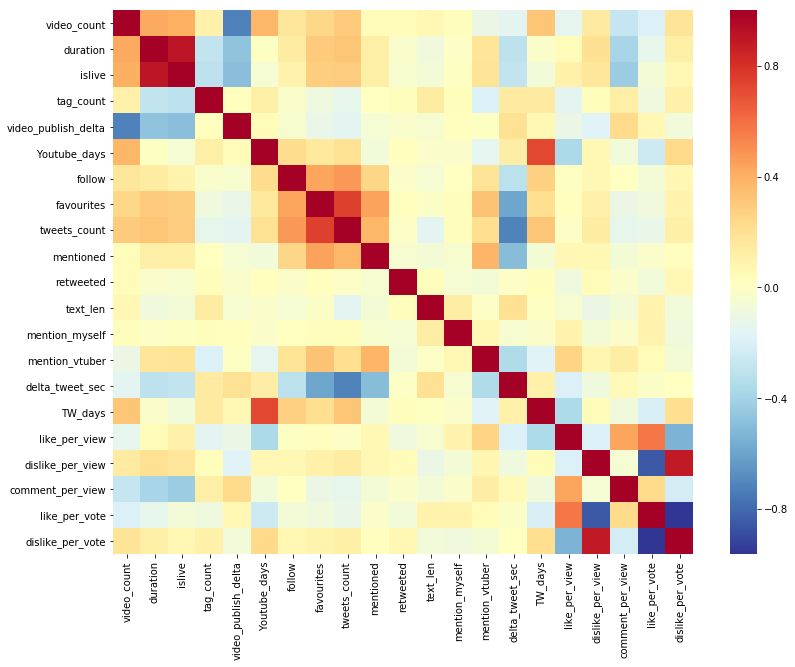

In [12]:
# 変数同士の相関を見る
plt.figure(figsize=(13, 10))
cormat = data[cordf.index[np.abs(cordf.cor) < 0.5]].corr(method="spearman")
sns.heatmap(cormat, cmap="RdYlBu_r")
plt.savefig("heatmap_spearman.png")

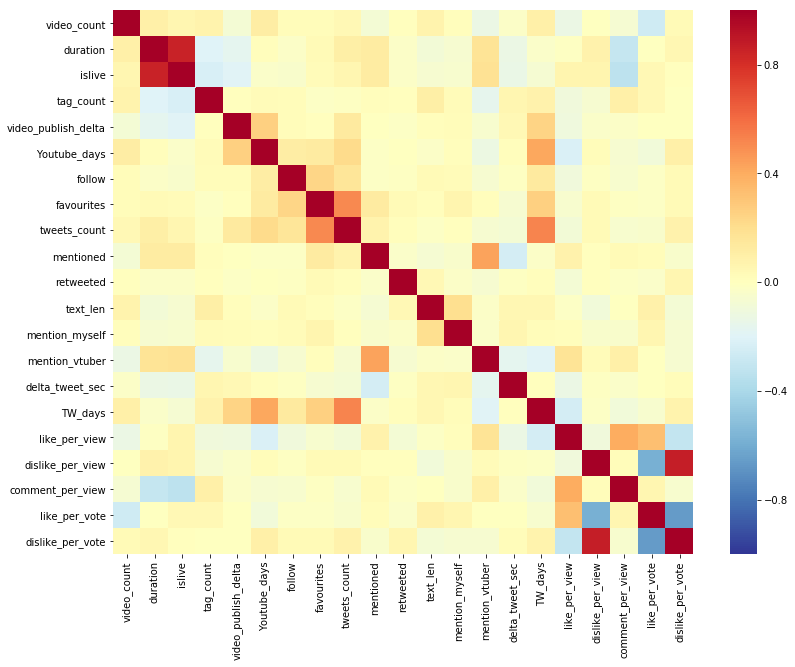

In [13]:
# 変数同士の相関を見る
plt.figure(figsize=(13, 10))
cormat = data[cordf.index[np.abs(cordf.cor) < 0.5]].corr(method="pearson")
sns.heatmap(cormat, cmap="RdYlBu_r", center=0, vmin=-1, vmax=1)
plt.savefig("corcor.png", dpi=300)

In [14]:
# 変数からカテゴリ値と登録者数ランクを削除
data = data.drop(["rank"] + data.select_dtypes("object").columns.tolist(), axis=1)

# 順位相関が0.5以上のものは今回は使わない
tmp = {}
for col in data.drop("fans", axis=1).columns:
    cor, p = spearmanr(data[col], data["fans"])
    tmp[col] = {"cor": cor, "p": p}

cordf = pd.DataFrame(tmp).T
select_col = cordf.index[np.abs(cordf.cor) < .5]

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# yは対数をとり、Xは正規化する
y = np.log10(data["fans"].values)
X = data[select_col].values
X = ss.fit_transform(X)

In [16]:
# 正則化の係数アルファを変化させながらl1回帰を行う

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

kf = KFold(n_splits=10, random_state=0, shuffle=True)
alphas = np.power(10, np.linspace(-3, 0, 100))

train_accuracy = []
test_accuracy = []
coefs = []
for alpha in tqdm(alphas):
    lasso = Lasso(alpha=alpha)
    train_tmp = []
    test_tmp = []
    coef_tmp = []
    for train, test in kf.split(range(X.shape[0])):
        lasso.fit(X[train], y[train])
        train_tmp.append(mean_squared_error(y[train], lasso.predict(X[train])))
        test_tmp.append(mean_squared_error(y[test], lasso.predict(X[test])))
        coef_tmp.append(lasso.coef_)
    train_accuracy.append(train_tmp)
    test_accuracy.append(test_tmp)
    coefs.append(coef_tmp)

train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
coefs = np.array(coefs)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 136.79it/s]


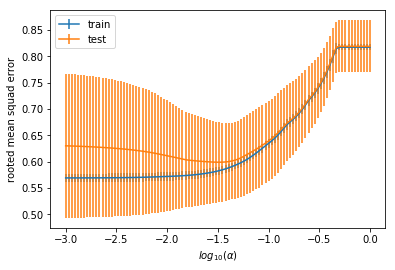

In [17]:
# アルファと予測値と実測値の平均二乗誤差の関係

plt.errorbar(np.log10(alphas), np.sqrt(train_accuracy.mean(axis=1)), train_accuracy.std(axis=1), label="train")
plt.errorbar(np.log10(alphas), np.sqrt(test_accuracy.mean(axis=1)), test_accuracy.std(axis=1), label="test")
plt.legend()
plt.xlabel(r"$log_{10}(\alpha)$")
plt.ylabel("rooted mean squad error")
plt.savefig("cv_rmse.png")

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 596.45it/s]
No handles with labels found to put in legend.


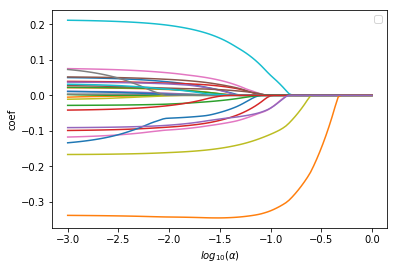

In [18]:
# 各係数の推移
for i in tqdm(range(X.shape[1])):
    plt.plot(np.log10(alphas), coefs[:, :, i].mean(axis=1))
plt.xlabel(r"$log_{10}(\alpha)$")
plt.ylabel("coef")
plt.legend()
plt.savefig("coef_path.png")

In [19]:
# 20%を評価用のセットとして取り出す

from numpy.random import choice
test = np.sort(choice(X.shape[0], 180, replace=False))
ix = np.ones(X.shape[0], dtype=np.bool)
ix[test] = False
train = np.arange(X.shape[0])[ix]

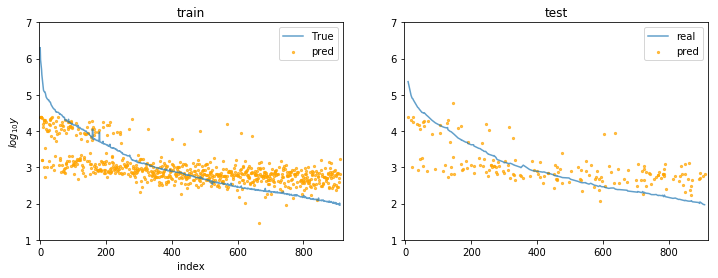

In [20]:
# 予測値と実測値の関係

lasso = Lasso(alpha=10**-1.3)
lasso.fit(X[train], y[train])
y_train_pred = lasso.predict(X[train])
y_test_pred = lasso.predict(X[test])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(train, y[train], label="True", alpha=0.7)
axs[0].scatter(train, y_train_pred, label="pred", alpha=0.7, c="orange", s=5)
axs[0].set_xlabel("index")
axs[0].set_ylabel("$log_{10}y$")
axs[0].legend()
axs[0].set_title("train")
axs[0].set_ylim(1, 7)
axs[0].set_xlim(-5, 920)

axs[1].plot(test, y[test], label="real", alpha=0.7)
axs[1].scatter(test, y_test_pred, label="pred", alpha=0.7, c="orange", s=5)
axs[1].legend()
axs[1].set_title("test")
axs[1].set_ylim(1, 7)
axs[1].set_xlim(-5, 920)

#print(*select_col[np.abs(lasso.coef_) > 0.01].tolist(), sep=", ")
plt.savefig("res_scat2.png")

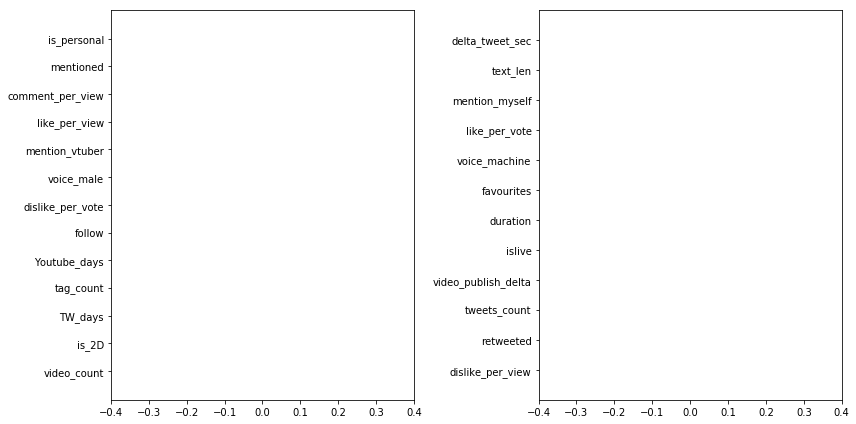

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
ims = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
C = coefs[50, :, :].mean(axis=0)
ixs = sorted(list(range(len(select_col))), key=lambda i: -abs(C[i]))

for i in range(99, -1, -1):
    im1 = ax1.barh(list(range(13)),
                   width=coefs[i, :, :].mean(axis=0)[ixs[:13][::-1]],
                   tick_label=select_col[ixs[:13][::-1]], color="b")
    im2 = ax2.barh(list(range(12)),
                   width=coefs[i, :, :].mean(axis=0)[ixs[13:][::-1]],
                   tick_label=select_col[ixs[13:][::-1]], color="b")
    ax1.set_xlim(-0.4, 0.4)
    ax2.set_xlim(-0.4, 0.4)
    ims.append([*im1, *im2])

plt.tight_layout()
ani = animation.ArtistAnimation(fig, ims)
#ani.save('anim.gif', writer="imagemagick")
ani.save('anim.mp4', writer="ffmpeg", fps=16)

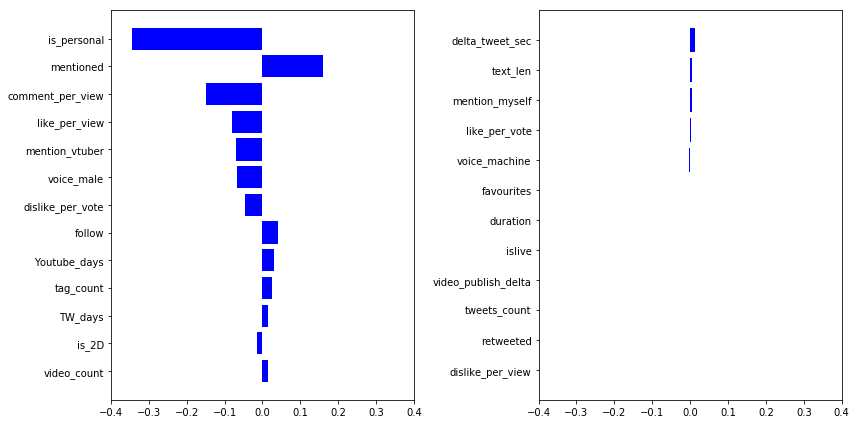

In [22]:
ims = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
X = coefs[50, :, :].mean(axis=0)
ixs = sorted(list(range(len(select_col))), key=lambda i: -abs(X[i]))


im1 = ax1.barh(list(range(13)),
               width=coefs[50, :, :].mean(axis=0)[ixs[:13][::-1]],
               tick_label=select_col[ixs[:13][::-1]], color="b")
im2 = ax2.barh(list(range(12)),
               width=coefs[50, :, :].mean(axis=0)[ixs[13:][::-1]],
               tick_label=select_col[ixs[13:][::-1]], color="b")
ax1.set_xlim(-0.4, 0.4)
ax2.set_xlim(-0.4, 0.4)
plt.tight_layout()
plt.savefig("coef_15.png", dpi=300)

Text(0.5,1,'$\\alpha = 10^{-1.5}$')

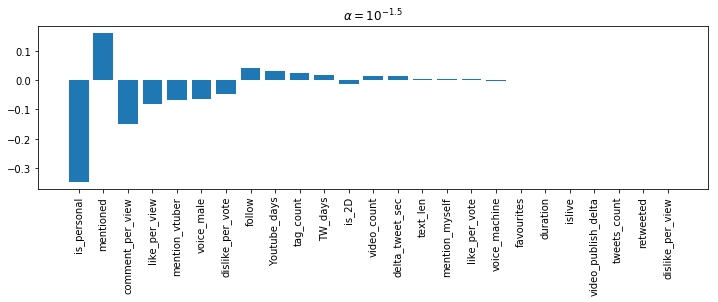

In [23]:
plt.figure(figsize=(12, 3))
X = coefs[50, :, :].mean(axis=0)
ixs = sorted(list(range(len(select_col))), key=lambda i: -abs(X[i]))
plt.bar(tick_label=select_col.values[ixs].tolist(), x=range(len(select_col)), height=X[ixs])
plt.xticks(rotation=90)
plt.title(r"$\alpha = 10^{-1.5}$")

In [24]:
?plt.xticks